# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* the pdf with your answers
* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [0]:
# Python 3.6 or above is required
from urllib.request import urlretrieve
from collections import defaultdict
import gzip
import numpy as np
from pathlib import Path
import os

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
cd '/content/drive/My Drive/'

/content/drive/My Drive


In [25]:
cd 'Centrale 3A '/OMA/DL

/content/drive/My Drive/Centrale 3A /OMA/DL


In [0]:
PATH_TO_DATA = Path('data/')
# Download word vectors, might take a few minutes and about ~3GB of storage space
en_embeddings_path = PATH_TO_DATA / 'cc.en.300.vec.gz'
if not en_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz', en_embeddings_path)
fr_embeddings_path = PATH_TO_DATA / 'cc.fr.300.vec.gz'
if not fr_embeddings_path.exists():
    urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.fr.300.vec.gz', fr_embeddings_path)

# 1) Monolingual (English) word embeddings 

In [0]:
import pdb

class Word2Vec():

    def __init__(self, filepath, vocab_size=50000):
        self.words, self.embeddings = self.load_wordvec(filepath, vocab_size)
        # Mappings for O(1) retrieval:
        self.word2id = {word: idx for idx, word in enumerate(self.words)}
        self.id2word = {idx: word for idx, word in enumerate(self.words)}
    
    def load_wordvec(self, filepath, vocab_size):
        assert str(filepath).endswith('.gz')
        words = []
        embeddings = []
        with gzip.open(filepath, 'rt') as f:  # Read compressed file directly
            next(f)  # Skip header
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                words.append(word)
                embeddings.append(np.fromstring(vec, sep=' '))
                if i == (vocab_size - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(words)))
        return words, np.vstack(embeddings)
    
    def encode(self, word):
        # Returns the 1D embedding of a given word
        #get word id
        id_word = self.word2id[word]
        return self.embeddings[id_word]
        #raise NotImplementedError('Fill in the blank')
    
    def score(self, word1, word2):
        # Return the cosine similarity: use np.dot & np.linalg.norm
        #compute embeddings
        word1_emb = self.encode(word1)
        word2_emb = self.encode(word2)
        #compute scalar product
        scalar_prod = np.dot(word1_emb, word2_emb)
        return scalar_prod/(np.linalg.norm(word1_emb)*np.linalg.norm(word2_emb))
        #raise NotImplementedError('Fill in the blank')
    
    def most_similar(self, word, k=5):
        # Returns the k most similar words: self.score & np.argsort
        sim_scores = [self.score(word, other_word) for other_word in self.words]
        most_similar_words = [self.id2word[idx] for idx in np.argsort(sim_scores)[::-1][:k]]
        
        return most_similar_words    
        #raise NotImplementedError('Fill in the blank')

In [8]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)

# You will be evaluated on the output of the following:
for word1, word2 in zip(('cat', 'cat', 'cat', 'Paris', 'Paris', 'Paris', 'Paris'), ('tree', 'dog', 'pet', 'France', 'Germany', 'baguette', 'donut')):
    print(word1, word2, word2vec.score(word1, word2))
for word in ['cat', 'dog', 'dogs', 'Paris', 'Germany']:
    print(f"{word2vec.most_similar(word)} are the most similar words to :{word}")

Loaded 50000 pretrained word vectors
cat tree 0.2644975466165475
cat dog 0.7078641298542562
cat pet 0.6753313359976381
Paris France 0.6892958925806542
Paris Germany 0.4051242286737548
Paris baguette 0.29399958277802224
Paris donut -0.006588507552348005
['cat', 'cats', 'kitty', 'kitten', 'feline'] are the most similar words to :cat
['dog', 'dogs', 'puppy', 'pup', 'canine'] are the most similar words to :dog
['dogs', 'dog', 'cats', 'puppies', 'Dogs'] are the most similar words to :dogs
['Paris', 'France', 'Parisian', 'Marseille', 'Brussels'] are the most similar words to :Paris
['Germany', 'Austria', 'Europe', 'Berlin', 'Hamburg'] are the most similar words to :Germany


In [0]:
class BagOfWords():
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        #self.idf_dict = None
        
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        # -> idf = {word: idf_value, ...}
        idf={}   
        # init phase: 
        idf={ word : 0 for word in self.word2vec.words }

        #count the number of occurences
        for s in sentences:
            if type(s) !=list:
                words = s.split(' ')
            else:
                words = s
            for word in words:
                if word in self.word2vec.words:
                    idf[word] += 1
        # constrcut the idf dict for each word
        idf_dict = {word: np.log(len(sentences)/vec) for word,vec in idf.items() if vec!=0 }
        return idf_dict
        
    def encode(self, sentence, idf):
        # Takes a sentence as input, returns the sentence embedding
        if type(sentence) !=list:
                words = sentence.split(' ')
        else:
                words = sentence

        if idf == None:
            # mean of word vectors
            sent_embed = np.mean([self.word2vec.encode(w) for w in words if w in self.word2vec.word2id],axis=0)
        else:
            # idf-weighted mean of word vectors
            sent_embed = np.mean([self.word2vec.encode(w)*idf[w] for w in words if w in self.word2vec.word2id],axis=0)
        return sent_embed


    def score(self, sentence1, sentence2, idf):
        # cosine similarity: use np.dot & np.linalg.norm 
        embedding1 = self.encode(sentence1, idf)
        embedding2  = self.encode(sentence2, idf)
        return np.dot(embedding1, embedding2)/(np.linalg.norm(embedding1)*np.linalg.norm(embedding2))

    
    def most_similar(self, sentence, sentences, idf, k=5):
        
        sim_scores = [self.score(sentence, key, idf) for key in sentences]
        most_similar_sentences = [sentences[idx] for idx in np.argsort(sim_scores)[len(sim_scores)-k-1:]]
        return most_similar_sentences 
        

In [10]:
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)

# Load sentences in "PATH_TO_DATA/sentences.txt"
filepath = PATH_TO_DATA / 'sentences.txt'
with open(filepath, 'r') as f:
    sentences = [line.strip('\n') for line in f]


# You will be evaluated on the output of the following:
print('\n\tAverage of word embeddings')
sentence1 = sentences[7]
sentence2 = sentences[13]
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, None))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences, None)  # BagOfWords-mean
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

    
# Build idf scores for each word
idf = sentence2vec.build_idf(sentences)

print('\n\tidf weighted average of word embeddings')
print(sentence1)
print(sentence2)
print(sentence2vec.score(sentence1, sentence2, idf))
sentence = sentences[10]
similar_sentences = sentence2vec.most_similar(sentence, sentences, idf)  # BagOfWords-idf
print(sentence)
for i, sentence in enumerate(similar_sentences):
    print(str(i+1) + ')', sentence)

Loaded 50000 pretrained word vectors

	Average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.7065220648251476
1 smiling african american boy . 
1) a young boy and 2 girls open christmas presents . 
2) 2 female babies eating chips . 
3) a small boy following 4 geese . 
4) 5 women and 1 man are smiling for the camera . 
5) 2 woman dancing while pointing . 
6) 1 smiling african american boy . 

	idf weighted average of word embeddings
1 man singing and 1 man playing a saxophone in a concert . 
10 people venture out to go crosscountry skiing . 
0.6230172138542661
1 smiling african american boy . 
1) 3 males and 1 woman enjoying a sporting event 
2) 5 women and 1 man are smiling for the camera . 
3) 2 guys facing away from camera , 1 girl smiling at camera with blue shirt , 1 guy with a beverage with a jacket on . 
4) two women and 1 man walking across the street . 
5) 1 man singing and 1 man playing a sax

# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [0]:
class MultilingualWordAligner:
    
    def __init__(self, fr_word2vec, en_word2vec):
        self.fr_word2vec = fr_word2vec
        self.en_word2vec = en_word2vec
        self.aligned_fr_embeddings = self.get_aligned_fr_embeddings()
        
    def get_aligned_fr_embeddings(self):
        # 1 - Get words that appear in both vocabs (= identical character strings)
        # Use it to create the matrix X (emb_dim, vocab_size) and Y (emb_dim, vocab_size) (of embeddings for these words)
        commun_vocab = [ w for w in self.en_word2vec.words if w in self.fr_word2vec.words]

        X, Y = [], []
        for word in commun_vocab:
              X.append(self.fr_word2vec.encode(word))
              Y.append(self.en_word2vec.encode(word))
        X = np.vstack(X).T
        Y = np.vstack(Y).T
        assert X.shape[0] == 300 and Y.shape[0] == 300


        
        # 2 - Solve the Procrustes using the numpy package and: np.linalg.svd() and get the optimal W
        #     Now self.fr_word2vec.embeddings * W.transpose() is in the same space as en_word2vec.embeddings

        U, S, V = np.linalg.svd(np.dot(Y,X.T),full_matrices=False)
        W = np.dot(U,V)
        assert W.shape == (300, 300)
        return np.matmul(fr_word2vec.embeddings, W.transpose())
        
    def get_closest_english_words(self, fr_word, k=3):
        # 3 - Return the top k English nearest neighbors to the input French word

        fr_word_emb = self.aligned_fr_embeddings[self.fr_word2vec.word2id[fr_word]]
        sim_scores = np.array([np.dot(fr_word_emb, en_word_emb)/(np.linalg.norm(fr_word_emb)*np.linalg.norm(en_word_emb)) for en_word_emb in self.en_word2vec.embeddings])
        most_similar_words = [self.en_word2vec.id2word[idx] for idx in np.argsort(sim_scores)[len(sim_scores)-k:]]
        return most_similar_words

In [12]:
fr_word2vec = Word2Vec(fr_embeddings_path, vocab_size=50000)
en_word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
multilingual_word_aligner = MultilingualWordAligner(fr_word2vec, en_word2vec)

# You will be evaluated on the output of the following:
fr_words = ['chat', 'chien', 'voiture', 'zut']
k = 3
for fr_word in fr_words:
    print('-' * 10)
    print(f'fr: "{fr_word}"')
    en_words = multilingual_word_aligner.get_closest_english_words(fr_word, k=3)
    for en_word in en_words: 
        print(f'en: "{en_word}"')

Loaded 50000 pretrained word vectors
Loaded 50000 pretrained word vectors
----------
fr: "chat"
en: "kitty"
en: "kitten"
en: "cat"
----------
fr: "chien"
en: "pet"
en: "cat"
en: "dog"
----------
fr: "voiture"
en: "automobile"
en: "vehicle"
en: "car"
----------
fr: "zut"
en: "ah"
en: "Ah"
en: "oops"


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [30]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)
PATH_TO_DATA = Path('data/')
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE

def read_sentences(path, put_label=False):
    sentences = []
    labels = []

    print('Loading sentences...')
    file = open(os.path.join(path), "r")
    for line in file:
        sentences.append(line.split()[1:]) 
        if put_label:
            labels.append(line.split()[0])
    labels = [int(labels[i]) for i in range(len(labels))]
    if put_label:
        return sentences, labels
    return sentences



train_sst, train_labels = read_sentences(train_filepath, put_label=True)
val_sst, val_labels = read_sentences(dev_filepath, put_label=True)
test_sst = read_sentences(test_filepath)
sentences_all = train_sst+val_sst+test_sst
print(f"train:{len(train_sst)}, val:{len(val_sst)}, test:{len(test_sst)}")
print('All sentences:',len(sentences_all))

Loading sentences...
Loading sentences...
Loading sentences...
train:8544, val:1101, test:2210
All sentences: 11855


In [31]:
# 2 - Encode sentences with the BoV model above
word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)
idf = sentence2vec.build_idf(sentences_all)

idf = {} if False else sentence2vec.build_idf(sentences_all)
X_train = np.vstack([sentence2vec.encode(sentence, idf) for sentence in train_sst])
y_train = np.array(train_labels)
X_val = np.vstack([sentence2vec.encode(sentence, idf) for sentence in val_sst])
y_val = np.array(val_labels)
X_test = np.vstack([sentence2vec.encode(sentence, idf) for sentence in test_sst])


Loaded 50000 pretrained word vectors


In [34]:
### Don't include idf :
X_train_0 = np.vstack([sentence2vec.encode(sentence,idf=None) for sentence in train_sst])
X_val_0 = np.vstack([sentence2vec.encode(sentence,idf=None) for sentence in val_sst])
X_test_0 = np.vstack([sentence2vec.encode(sentence,idf=None) for sentence in test_sst])

print(np.shape(X_test_0))

(2210, 300)


In [19]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)
#     In the paper, the accuracy for average of word vectors is 32.7%
#     (VecAvg, table 1, https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# With idf input
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=0, penalty='l2',max_iter=2000,C=1)
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
val_pred = lr.predict(X_val)

print('Precision on train set', round(accuracy_score(train_labels,train_pred),4)*100,'%')
print('Precision on val set', round(accuracy_score(val_labels,val_pred),4)*100,'%')


Precision on train set 47.260000000000005 %
Precision on val set 41.24 %


In [41]:
# Without idf input 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
lr0 = LogisticRegression(random_state=0, penalty='l2',max_iter=2000,C=1)
lr0.fit(X_train_0, y_train)
train_pred0 = lr0.predict(X_train_0)
val_pred0 = lr0.predict(X_val_0)
print('Without idf')
print('Precision on train set', round(accuracy_score(train_labels,train_pred0),4)*100,'%')
print('Precision on val set', round(accuracy_score(val_labels,val_pred0),4)*100,'%')


Without idf
Precision on train set 42.86 %
Precision on val set 39.06 %


In [16]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
test_pred = lr.predict(X_test)
np.savetxt('logreg_bov_y_test_sst.txt', test_pred .astype(int), delimiter=',') 
print('Number of predictions = ', test_pred.shape[0])

Number of predictions =  2210


In [17]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE

### Here we used lightgbm
import lightgbm as lgb
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(max_depth=3,n_estimators=500,reg_lambda=1)

lgbm.fit(X_train, y_train, early_stopping_rounds=30,eval_set=[(X_val, y_val)])
train_pred = lgbm.predict(X_train)
val_pred = lgbm.predict(X_val)

print('Precision on train set', round(accuracy_score(train_labels,train_pred),4)*100,'%')
print('Precision on val set', round(accuracy_score(val_labels,val_pred),4)*100,'%')


[1]	valid_0's multi_logloss: 1.56375
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.55536
[3]	valid_0's multi_logloss: 1.54748
[4]	valid_0's multi_logloss: 1.54141
[5]	valid_0's multi_logloss: 1.53578
[6]	valid_0's multi_logloss: 1.52998
[7]	valid_0's multi_logloss: 1.52431
[8]	valid_0's multi_logloss: 1.51899
[9]	valid_0's multi_logloss: 1.51392
[10]	valid_0's multi_logloss: 1.50961
[11]	valid_0's multi_logloss: 1.50551
[12]	valid_0's multi_logloss: 1.50151
[13]	valid_0's multi_logloss: 1.49782
[14]	valid_0's multi_logloss: 1.49423
[15]	valid_0's multi_logloss: 1.49076
[16]	valid_0's multi_logloss: 1.48759
[17]	valid_0's multi_logloss: 1.4838
[18]	valid_0's multi_logloss: 1.4799
[19]	valid_0's multi_logloss: 1.4772
[20]	valid_0's multi_logloss: 1.47458
[21]	valid_0's multi_logloss: 1.47193
[22]	valid_0's multi_logloss: 1.46947
[23]	valid_0's multi_logloss: 1.46715
[24]	valid_0's multi_logloss: 1.46565
[25]	valid_0's multi_logloss: 1.46341


In [43]:
## Without idf-weighted-average
import lightgbm as lgb
from lightgbm import LGBMClassifier

lgbm0 = LGBMClassifier(max_depth=3,n_estimators=500,reg_lambda=1)

lgbm0.fit(X_train_0, y_train, early_stopping_rounds=30,eval_set=[(X_val_0, y_val)])
train_pred0 = lgbm0.predict(X_train_0)
val_pred0 = lgbm0.predict(X_val_0)

print('Precision on train set', round(accuracy_score(train_labels,train_pred0),4)*100,'%')
print('Precision on val set', round(accuracy_score(val_labels,val_pred0),4)*100,'%')

[1]	valid_0's multi_logloss: 1.5658
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's multi_logloss: 1.55954
[3]	valid_0's multi_logloss: 1.55357
[4]	valid_0's multi_logloss: 1.54716
[5]	valid_0's multi_logloss: 1.543
[6]	valid_0's multi_logloss: 1.53871
[7]	valid_0's multi_logloss: 1.5346
[8]	valid_0's multi_logloss: 1.53028
[9]	valid_0's multi_logloss: 1.52653
[10]	valid_0's multi_logloss: 1.52226
[11]	valid_0's multi_logloss: 1.51989
[12]	valid_0's multi_logloss: 1.51653
[13]	valid_0's multi_logloss: 1.51261
[14]	valid_0's multi_logloss: 1.51025
[15]	valid_0's multi_logloss: 1.50775
[16]	valid_0's multi_logloss: 1.50557
[17]	valid_0's multi_logloss: 1.50307
[18]	valid_0's multi_logloss: 1.50063
[19]	valid_0's multi_logloss: 1.49831
[20]	valid_0's multi_logloss: 1.49593
[21]	valid_0's multi_logloss: 1.49378
[22]	valid_0's multi_logloss: 1.49101
[23]	valid_0's multi_logloss: 1.48927
[24]	valid_0's multi_logloss: 1.48786
[25]	valid_0's multi_logloss: 1.48628
[

In [18]:
test_pred = lgbm.predict(X_test)
np.savetxt('lgb_bov_y_test_sst.txt', test_pred.astype(int), delimiter=',') 
print('Number of predictions = ', test_pred.shape[0])

Number of predictions =  2210


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [10]:
import keras
from keras.preprocessing import text
from keras.utils import to_categorical
import tensorflow as tf

Using TensorFlow backend.


In [11]:
train_filepath = PATH_TO_DATA / 'SST/stsa.fine.train'
dev_filepath = PATH_TO_DATA / 'SST/stsa.fine.dev'
test_filepath = PATH_TO_DATA / 'SST/stsa.fine.test.X'

# TYPE CODE HERE

def read_sentences(path, put_label=False):
    sentences = []
    labels = []

    print('Loading sentences...')
    file = open(os.path.join(path), "r")
    for line in file:
        sentences.append(line.split()[1:]) 
        if put_label:
            labels.append(line.split()[0])
    labels = [int(labels[i]) for i in range(len(labels))]
    if put_label:
        return sentences, labels
    return sentences



train_sst, train_labels = read_sentences(train_filepath, put_label=True)
val_sst, val_labels = read_sentences(dev_filepath, put_label=True)
test_sst = read_sentences(test_filepath)
sentences_all = train_sst+val_sst+test_sst
print(f"train:{len(train_sst)}, val:{len(val_sst)}, test:{len(test_sst)}")
print('All sentences:',len(sentences_all))


Loading sentences...
Loading sentences...
Loading sentences...
train:8544, val:1101, test:2210
All sentences: 11855


In [12]:

word2vec = Word2Vec(en_embeddings_path, vocab_size=50000)
sentence2vec = BagOfWords(word2vec)
idf = sentence2vec.build_idf(sentences_all)

idf = {} if False else sentence2vec.build_idf(sentences_all)
X_train = np.vstack([sentence2vec.encode(sentence, idf) for sentence in train_sst])
y_train = np.array(train_labels)
X_val = np.vstack([sentence2vec.encode(sentence, idf) for sentence in val_sst])
y_val = np.array(val_labels)
X_test = np.vstack([sentence2vec.encode(sentence, idf) for sentence in test_sst])


Loaded 50000 pretrained word vectors


In [0]:
# 1 - Using the same dataset, transform text to integers using tf.keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/


# TYPE CODE HERE
vocab_size =50000
X_train_oh = [text.one_hot(' '.join(sentence), vocab_size) for sentence in train_sst]
X_val_oh = [text.one_hot(' '.join(sentence), vocab_size) for sentence in val_sst]
X_test_oh = [text.one_hot(' '.join(sentence), vocab_size) for sentence in test_sst]




**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [14]:
# 2 - Pad your sequences using tf.keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences

max_train = max([len(X_train[i]) for i in range(len(X_train))])
max_val = max([len(X_val[i]) for i in range(len(X_val))])
max_test = max([len(X_test[i]) for i in range(len(X_test))])

max_length = max([max_train, max_val , max_test])
print('max lengths :', max_train)

#max_length =50 
# Do padding to get the same lengths
X_train_pad = pad_sequences(X_train_oh, maxlen=max_length)
X_val_pad = pad_sequences(X_val_oh, maxlen=max_length)
X_test_pad = pad_sequences(X_test_oh,maxlen=max_length)

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

print('train shape',np.shape(X_train_pad))
print('val shape',np.shape(X_val_pad))
print('test shape',np.shape(X_test_pad))

print('train label shape',np.shape(y_train_cat))
print('val label shape',np.shape(y_val_cat))

max lengths : 300
train shape (8544, 300)
val shape (1101, 300)
test shape (2210, 300)
train label shape (8544, 5)
val label shape (1101, 5)


## 4.2 - Design and train your model

In [15]:
# 3 - Design your encoder + classifier using tensorflow.keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this container : the lookup-table, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.
#     Note that the embedding layer is initialized randomly and does not take advantage of pre-trained word embeddings.


# ADAPT CODE BELOW

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional 

import os
import pdb

embed_dim  = 32  # word embedding dimension
nhid       = 64  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5
#Initialize the embedding weights





model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(n_classes, activation='sigmoid'))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [16]:
# 4 - Define your loss/optimizer/metrics
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'rmsprop' # find the right optimizer
metrics_classif  =  ['accuracy']
# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          1600000   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 1,625,157
Trainable params: 1,625,157
Non-trainable params: 0
_________________________________________________________________
None


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8544 samples, validate on 1101 samples
Epoch 1/15
8544/8544 [==============================] - 69s 8ms/sample - loss: 1.5767 - acc: 0.2684 - val_loss: 1.5700 - val_acc: 0.2870
Epoch 2/15
8544/8544 [==============================] - 69s 8ms/sample - loss: 1.5567 - acc: 0.2973 - val_loss: 1.5305 - val_acc: 0.3152
Epoch 3/15
8544/8544 [==============================] - 69s 8ms/sample - loss: 1.4707 - acc: 0.3635 - val_loss: 1.4339 - val_acc: 0.3715
Epoch 4/15
8544/8544 [==============================] - 69s 8ms/sample - loss: 1.3573 - acc: 0.4059 - val_loss: 1.3924 - val_acc: 0.3842
Epoch 5/15
8544/8544 [==============================] - 69s 8ms/sample - loss: 1.2613 - acc: 0.4322 - val_loss: 1.3810 - val_acc: 0.3915
Epoch 6/15
8544/8544 [==============================] - 68s 8ms/sample - loss: 1.1863 - acc: 0.4538 - val_loss: 1.3984 - val_acc: 0.3815
Epoch 7/15
8544/8544 [==============

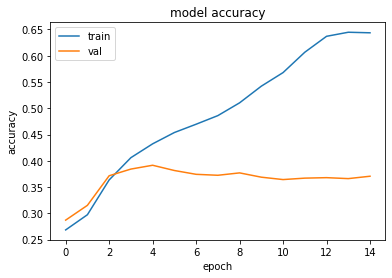

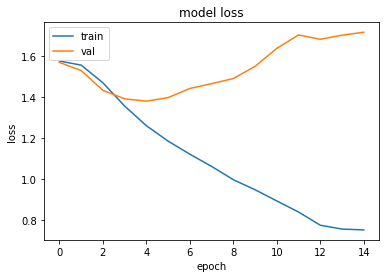

In [17]:
# 5 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set
#     Keras expects y_train and y_dev to be one-hot encodings of the labels, i.e. with shape=(n_samples, 5)


# ADAPT CODE BELOW
bs =64
n_epochs = 15
import matplotlib.pyplot as plt
%matplotlib inline


mcp = ModelCheckpoint('.mdl_lstm.hdf5', monitor="val_acc", mode='max',save_best_only=True, save_weights_only=False)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

history = model.fit(X_train_pad, y_train_cat, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_val_pad, y_val_cat), callbacks = [mcp,lr_scheduler])

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [19]:
# 6 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.


# TYPE CODE HERE
model =tf.keras.models.load_model('.mdl_lstm.hdf5') #best val accuracy: 0.3915
print(np.shape(X_test_oh))
prediction_test = np.argmax(model.predict(X_test_pad),axis=1)

with open('./logreg_lstm_y_test_sst.txt', 'w') as f1:
    for k in prediction_test:
        f1.write(str(k) + os.linesep)
    


(2210,)


## 4.3 - innovate: ! 

In [18]:
# 7 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dropout, Conv1D, Flatten, GlobalMaxPooling1D,MaxPooling1D
from tensorflow.keras.layers import Bidirectional 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score
embed_dim  = 300  # word embedding dimension
nhid       = 50  # number of hidden units in the LSTM
vocab_size = 50000  # size of the vocabulary
n_classes  = 5


mcp1 = ModelCheckpoint('weights.model_innovate.hdf5', monitor="val_acc",save_best_only=True, save_weights_only=False)

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5))
model.add(Bidirectional(LSTM(nhid, dropout=0.4, recurrent_dropout=0.3,return_sequences=False))) #bidirectional LSTM layer
model.add(Dense(n_classes, activation='sigmoid'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'adam' # find the right optimizer
metrics_classif  =  ['accuracy']
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

bs = 64
n_epochs = 6

history = model.fit(X_train_pad, y_train_cat, batch_size=bs, nb_epoch=n_epochs, validation_data=(X_val_pad, y_val_cat), callbacks = [mcp1,lr_scheduler])
print(history.history.keys())



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 300)         15000000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 32)          28832     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 32)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               33200     
______________________________

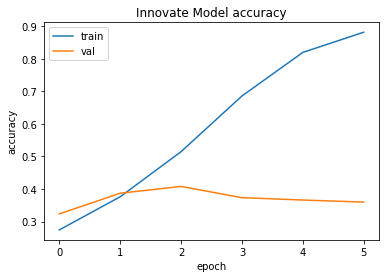

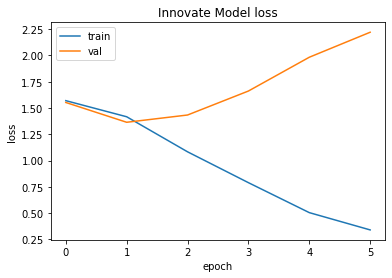

In [20]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Innovate Model accuracy')

plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Innovate Model loss')
plt.show()

In [0]:
## Load the model
model =tf.keras.models.load_model('weights.model_innovate.hdf5') #best val accuracy: 0.408


In [21]:
## Perform prediction 
prediction_test = np.argmax(model.predict(X_test_pad),axis=1)
## export results
with open('./innovate_lstm_y_test_sst.txt', 'w') as f1:
    for k in prediction_test:
        f1.write(str(k) + os.linesep)
    

(2210,)
